In [6]:
from machinelearning.mlpipeline import MLPipelines

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import optuna
# from sklearn.preprocessing import LabelEncoder ###
# from sklearn.cross_decomposition import PLSRegression

# model = LogisticRegression()
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1],
#     'penalty': ['l1', 'l2']
# }
csv_dir = 'data/composite_dataset.csv'
label = 'group'

model = LogisticRegression()
param_grid = {
    'n_estimators': [10, 20, 50],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# mlpipe = MLPipelines(estimator=model, param_grid=param_grid, label=label, csv_dir=csv_dir)
# mlpipe.normalize()

In [7]:
# dataloader
mlpipe = MLPipelines(estimator=model, param_grid={}, label=label, csv_dir=csv_dir)
# mlpipe._encode_labels()
mlpipe.normalize()

Label mapping: {'Factor1:CASE': 0, 'Factor1:CONTROL': 1}


In [8]:
# mlpipe.bayesian_search()
# xg = [RandomForestClassifier(), GradientBoostingClassifier(), LinearDiscriminantAnalysis(), LogisticRegression(), GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier(), SVC()]
xg = [RandomForestClassifier(), XGBClassifier(), LogisticRegression(), GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier(), SVC()]

  0%|          | 0/2 [00:00<?, ?it/s]

Performing nested cross-validation for GradientBoostingClassifier...
Performing nested cross-validation for GradientBoostingClassifier...


[I 2024-01-14 20:17:42,185] A new study created in memory with name: no-name-0865842a-9f60-4e5a-89db-6cf50ec48e7f
[I 2024-01-14 20:17:42,205] A new study created in memory with name: no-name-3a313acd-613c-4edd-8285-a2ef77f0cb36
[I 2024-01-14 20:17:42,212] A new study created in memory with name: no-name-c71814c0-c73b-429c-867a-ace327f811af
[I 2024-01-14 20:17:42,218] A new study created in memory with name: no-name-f78aeac5-ea89-442e-a07d-9b837df9e00c
[I 2024-01-14 20:17:42,229] A new study created in memory with name: no-name-9a218c5d-4f33-439b-b1c6-7d310d0179ba
[I 2024-01-14 20:17:42,853] Trial 0 finished with value: 0.7115009746588695 and parameters: {'loss': 'exponential', 'learning_rate': 0.27071276963093943, 'n_estimators': 19, 'criterion': 'squared_error', 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7115009746588695.
[I 2024-01-14 20:17:43,748] Trial 1 finished with value: 0.8070175438596491 and parameters: {'loss': 'exponentia

Performing nested cross-validation for LinearDiscriminantAnalysis...
Performing nested cross-validation for LinearDiscriminantAnalysis...


[I 2024-01-14 20:17:53,650] A new study created in memory with name: no-name-02eb9641-a508-4ceb-af6d-0d317635b993
[I 2024-01-14 20:17:53,650] A new study created in memory with name: no-name-bc27af8f-9fea-4af3-bd4c-b81dd0897d6f
[I 2024-01-14 20:17:53,650] A new study created in memory with name: no-name-30853f1b-d9e8-4432-83c7-7e2ff07cd328
[I 2024-01-14 20:17:53,654] A new study created in memory with name: no-name-600b83da-e7f2-40ee-8689-1bf222f170f1
[I 2024-01-14 20:17:53,654] A new study created in memory with name: no-name-9c833ea0-91ef-4015-82bf-a3f8a2afb356
[I 2024-01-14 20:17:58,126] Trial 0 finished with value: 0.5536062378167641 and parameters: {'solver': 'lsqr', 'shrinkage': 0.1157170975887235, 'tol': 0.001, 'store_covariance': False}. Best is trial 0 with value: 0.5536062378167641.
[I 2024-01-14 20:17:58,317] Trial 1 finished with value: 0.6140350877192983 and parameters: {'solver': 'lsqr', 'shrinkage': 0.5658846653860069, 'tol': 0.001, 'store_covariance': True}. Best is tri

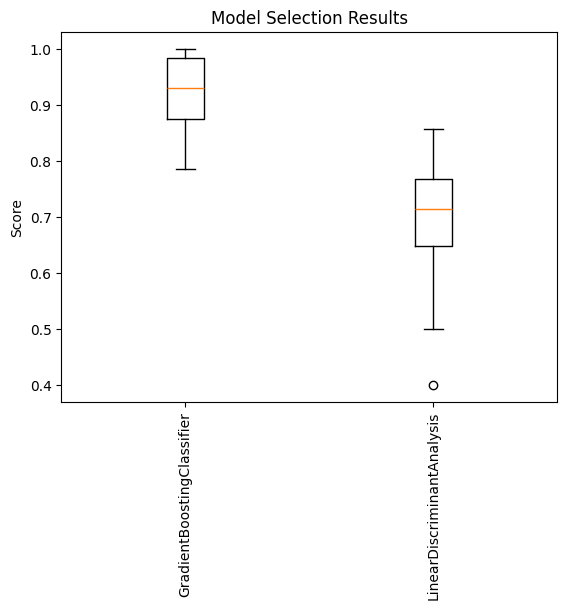

[I 2024-01-14 20:18:11,453] A new study created in memory with name: no-name-c56878f3-dfe9-48bb-83bf-1b5be5e71363
[I 2024-01-14 20:18:14,785] Trial 0 finished with value: 0.8752380952380951 and parameters: {'loss': 'log_loss', 'learning_rate': 0.4368769224850903, 'n_estimators': 151, 'criterion': 'squared_error', 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8752380952380951.
[I 2024-01-14 20:18:22,934] Trial 1 finished with value: 0.9161904761904761 and parameters: {'loss': 'log_loss', 'learning_rate': 0.10511485917108726, 'n_estimators': 171, 'criterion': 'squared_error', 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.9161904761904761.
[I 2024-01-14 20:18:26,744] Trial 2 finished with value: 0.8590476190476191 and parameters: {'loss': 'log_loss', 'learning_rate': 0.1715820185250575, 'n_estimators': 52, 'criterion': 'friedman_mse', 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf

For the GradientBoostingClassifier model: 
Best parameters: {'loss': 'exponential', 'learning_rate': 0.29910183640760446, 'n_estimators': 172, 'criterion': 'squared_error', 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 5}
Best accuracy: 0.9295238095238094


In [9]:
# mlpipe.nested_cross_validation(optimizer='bayesian_search',n_iter=5, n_trials=10)
res = mlpipe.model_selection(optimizer='bayesian_search',n_trials=2,num_trials=2,score='accuracy',exclude=xg, n_iter=2, train_best='bayesian_search')#, exclude=[XGBClassifier()],result=True)